In [10]:
import matplotlib.pyplot as plt
import numpy as np
import xml.etree.ElementTree as ET
import pickle

import torch.utils.data

In [11]:
#CAMERA INTRINSICS FROM METASHAPE xml FILE
def get_cam_intrinsics(root):
    camera_intrinsics = []
    y = []
    for node in root.iter("calibration"):
        x = list(node.attrib.values())
        if (x[1]=="adjusted"):
            for node2 in node.iter():
                camera_intrinsics.append(node2.text)
                y.append(list(node2.attrib.values()))
    camera_intrinsics = list(map(float,camera_intrinsics[2:]))
    width, height = list(map(float,y[1]))
    camera_intrinsics_dict = {"width":width,
                              "height":height,
                              "f":camera_intrinsics[0],
                              "cx":camera_intrinsics[1],
                              "cy":camera_intrinsics[2],
                              "b1":camera_intrinsics[3],
                              "b2":camera_intrinsics[4],
                              "k1":camera_intrinsics[5],
                              "k2":camera_intrinsics[6],
                              "k3":camera_intrinsics[7],
                              "k4":camera_intrinsics[8],
                              "p1":camera_intrinsics[9],
                              "p2":camera_intrinsics[10]}
    return camera_intrinsics_dict

In [12]:
#CAMERA POSE PER IMAGE ID
def get_cam_pose(root):
    camera = []
    for cam in root.iter("camera"):
        camera_id = int(list(cam.attrib.values())[0])
        img_id = list(cam.attrib.values())[-1]
        #print(camera_id, img_id)
        for item in cam.iter("transform"):
            val = np.matrix(item.text)
            transform_mat = np.reshape(val, (4,4))
            #print(transform_mat)
        for item in cam.iter("reference"):
            ref = item.attrib
            #print(ref)
        camera_dict = {"image_id" : img_id,
                            "transform_mat" : transform_mat,
                            "reference" : ref}
        camera.append(camera_dict)
    return camera

In [9]:
file = "/home/turin/Desktop/lizard_dataset_curated/2014/cam14.xml"
tree = ET.parse(file)
root = tree.getroot()
camera_intrinsics = get_cam_intrinsics(root)
# file = open('/home/turin/Documents/GitHub/long_term_underwater_vision/dataset/camera_itrs', 'wb')
# pickle.dump(camera_intrinsics, file)
# file.close()
camera_pose = get_cam_pose(root)
pose = []
cam_id = []
cam_pose = []
for idx in range (len(camera_pose)):
    cam_ref = [0,0,0,0,0,0]
    cam_id = camera_pose[idx]["image_id"]
    cam_pose = camera_pose[idx]["transform_mat"]
    cam_ref[0] = float(camera_pose[idx]["reference"]["x"])-332400
    cam_ref[1] = float(camera_pose[idx]["reference"]["y"])-8375600
    cam_ref[2] = float(camera_pose[idx]["reference"]["z"])
    cam_ref[3] = float(camera_pose[idx]["reference"]["yaw"])
    cam_ref[4] = float(camera_pose[idx]["reference"]["pitch"])
    cam_ref[5] = float(camera_pose[idx]["reference"]["roll"])
    pose.append([cam_id, cam_pose, cam_ref])
pose = np.asarray(pose)
file = open('image_id', 'wb')
pickle.dump(pose, file)
file.close()

/tmp/ipykernel_9681/2506574221.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pose = np.asarray(pose)


In [13]:
#BASED ON REFERENCE
# var = open("image_id", 'rb')
# v = pickle.load(var)
v = pose
thres = .37
neg_thres = 2
dict_group = {}
for idx in range(len(v)):
    group = []
    neg_group = []
    for idy in range(len(v)):
        mat1 = v[idx][2]
        mat2 = v[idy][2]
        if mat1[0]-thres<mat2[0]<mat1[0]+thres and mat1[1]-thres<mat2[1]<mat1[1]+thres: #and mat1[2]-thres<mat2[2]<mat1[2]+thres:
            group.append(v[idy])
        if (mat2[0] < mat1[0]-neg_thres or mat2[0]>mat1[0]+neg_thres) and (mat2[1] < mat1[1]-neg_thres or mat2[1]>mat1[1]+neg_thres):
            neg_group.append(v[idy])
    # print(len(group))
    # print(len(neg_group))
    if len(neg_group)>2:
        neg_group_reduced = neg_group[:len(group)]
    dict_group[v[idx][0]] = [group, neg_group_reduced]
# file = open('camera_group', 'wb')
# pickle.dump(dict_group, file)
# file.close

In [6]:
#BASED ON TRANSFORMATION MAT
# var = open("image_id", 'rb')
# v = pickle.load(var)
# thres = 2
# neg_thres = 60
# dict_group = {}
# for idx in range(len(v)):
#     group = []
#     neg_group = []
#     for idy in range(len(v)):
#         mat1 = v[idx][1]
#         mat2 = v[idy][1]
#         if mat1[0,3]-thres<mat2[0,3]<mat1[0,3]+thres and mat1[1,3]-thres<mat2[1,3]<mat1[1,3]+thres and mat1[2,3]-thres<mat2[2,3]<mat1[2,3]+thres:
#             group.append(v[idy])
#         if (mat2[0,3] < mat1[0,3]-neg_thres or mat2[0,3]>mat1[0,3]+neg_thres) and (mat2[1,3] < mat1[1,3]-neg_thres or mat2[1,3]>mat1[1,3]+neg_thres):
#             neg_group.append(v[idy])
#     if len(neg_group)>2:
#         neg_group_reduced = neg_group[:len(group)]
#     dict_group[v[idx][0]] = [group, neg_group_reduced]
# file = open('camera_group', 'wb')
# pickle.dump(dict_group, file)
# file.close

In [21]:
trans_mat = np.asarray([[-8.94745577e-01,  2.42987917e-01,  2.66707894e-02,  7.81576422e+01],
 [-2.43542169e-01, -8.94811458e-01, -1.79936861e-02,  1.21915754e+02],
 [ 2.10159686e-02, -2.43604764e-02,  9.26978426e-01,  1.39741412e+00],
 [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])
trans_mat

array([[-8.94745577e-01,  2.42987917e-01,  2.66707894e-02,
         7.81576422e+01],
       [-2.43542169e-01, -8.94811458e-01, -1.79936861e-02,
         1.21915754e+02],
       [ 2.10159686e-02, -2.43604764e-02,  9.26978426e-01,
         1.39741412e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [7]:
import os
import shutil
# file1 = open('camera_group', 'rb')
# camera_group = pickle.load(file1)
# file1.close
camera_group = dict_group
path = "/home/turin/Desktop/lizard_jackson/chronological/2014/r20141102_074952_lizard_d2_081_horseshoe_circle01/081_photos/"
for idx in (os.listdir(path)):
    new_path = "/home/turin/Desktop/lizard_dataset_curated/dataset_group/" + idx[:-4]
    os.mkdir(new_path)
    for idy in camera_group[idx][0]:
        #print(idy[0])
        org_path = path + idy[0]
        shutil.copy(org_path,new_path)


FileExistsError: [Errno 17] File exists: '/home/turin/Desktop/lizard_dataset_curated/dataset_group/PR_20141102_075303_103_LC16'

In [8]:
x = list(camera_group.keys())
for idx in x:
    #print(camera_group[idx][0])
    for idy in range(1,len(camera_group[idx][0])):
        #print(camera_group[idx][idy])
        if camera_group[idx][0][0][1][0,3]==camera_group[idx][0][idy][1][0,3]:
            print("Wrong Grouping: Duplicate Transform mat detected at ", idx)

In [9]:
data_pos = []
data_neg = []
label_pos = []
label_neg = []
x = list(camera_group.keys())
xx = 0
org_dict = {}
for idx in range(len(v)):
    org_dict[v[idx][0]] = v[idx][1]
for idx in x:
    for idy in range(0,len(camera_group[idx][0])):
        im_p1 = idx
        im_p2 = camera_group[idx][0][idy][0]
        if im_p1!=im_p2:
            #print(im_p1, im_p2)
            data_pos.append([im_p1, im_p2])
            label_pos.append([1,[org_dict[im_p1], org_dict[im_p2]]])
    for idn in range(0,len(camera_group[idx][1])):
        im_n1 = idx
        im_n2 = camera_group[idx][1][idn][0]
        if im_n1!=im_n2:
            #print(im_p1, im_p2)
            data_neg.append([im_n1, im_n2])
            label_neg.append([0,[org_dict[im_n1], org_dict[im_n2]]])

In [10]:
#Testing if every group is legit:
var = open("image_id", 'rb')
v = pickle.load(var)
good = 0
for itr in range(len(data_pos)):
    im1 = data_pos[itr][0]
    im2 = data_pos[itr][1]
    if (label_pos[itr][1][0] == org_dict[im1]).all() and (label_pos[itr][1][1] == org_dict[im2]).all():
        good+=1
    else:
        print("Problem found at ", itr)
        break
dataset_positive = (data_pos, label_pos)
dataset_negative = (data_neg, label_neg)

In [11]:
file = open('/home/turin/Documents/GitHub/long_term_underwater_vision/dataset/dataset_positive', 'wb')
pickle.dump(dataset_positive,file)
file.close
file1 = open('/home/turin/Documents/GitHub/long_term_underwater_vision/dataset/dataset_negative', 'wb')
pickle.dump(dataset_negative,file1)
file1.close

<function BufferedWriter.close>

In [12]:
plot3d = []
colors = []
clr_init = 0
for idx in range(len(x)):
    plot3d.append(camera_group[x[idx]][0][0][2][:3])
    colors.append([idx/1600,1.0-(idx/1600),.1])
plot3d = np.asarray(plot3d)

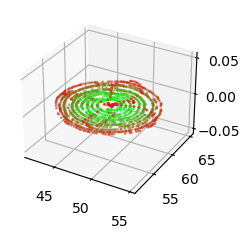

In [13]:
plt.style.use('_mpl-gallery')
xs = plot3d[:,0]
ys = plot3d[:,1]
zs = plot3d[:,2]
z = np.zeros(1600)
rgb = np.asarray([.5,.8,.1])

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(xs, ys, z, s=1, c=colors, alpha=0.5)
# ax.set_xlabel('x dist', fontsize = 5)
# ax.set_ylabel("y dist", fontsize = 5)
# ax.set_zlabel("z dist", fontsize = 5)
plt.savefig("camera_area_depth zero.png", bbox_inches="tight", dpi = 600,)
plt.show()


In [19]:
import numpy as np
x = np.asarray([[ 0.93188237,  0.00785442,  0.02757995,  1.27660544],
       [-0.00684264,  0.93167355, -0.03412714,  3.52793686],
       [-0.02784823,  0.03390857,  0.93129038,  0.49316502],
       [ 0.0      ,  0.0        ,  0.0        ,  1.0        ]])
y = np.asarray([[9.53340733e-01, 2.97331996e-03, 2.74878773e-02,
          4.56269403e-01],
         [-1.97374551e-03, 9.53110160e-01, -3.46425247e-02,
          2.11840944e+00],
         [-2.75776787e-02, 3.45710798e-02, 9.52715744e-01,
          5.16001960e-01],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          1.00000000e+00]])

In [23]:
o = np.asarray([[35],[21],[20],[1]])
z1 = x@o
z2 = y@o
z3 = xx@o

In [24]:
z1, z2, z3

(array([[34.60903021],
        [22.17104621],
        [18.85636454],
        [ 1.        ]]),
 array([[34.43539232],
        [21.37179121],
        [19.33109076],
        [ 1.        ]]),
 array([[35.25573584],
        [21.64871634],
        [18.96728347],
        [ 1.        ]]))

In [16]:
xx = np.asarray([[ 0.93772987, -0.01210513,  0.02776278,  2.13414252],
       [ 0.01311187,  0.93750722, -0.03410151,  2.18417947],
       [-0.02730174,  0.03447173,  0.93718778,  0.45518244],
       [ 0.0        ,  0.0       ,  0.0    ,  1.0       ]])

array([[ 4.86764809e-01,  8.01246090e-01, -3.63227125e-02,
         1.77256769e+01],
       [ 8.02038355e-01, -4.85875627e-01,  3.02320001e-02,
        -9.20311025e+00],
       [ 7.00790609e-03, -4.67354558e-02, -9.37027911e-01,
         2.17429367e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [25]:
pose15 = np.asarray([[0.5302770289722869, 0.8477747187138337, -0.0091814407368312548, 16.386626980418566],
[0.84778421767412615, -0.53032626049101128, -0.0039972110639367071, -12.275019923118222],
[-0.0082578936172523227, -0.0056642513450363315, -0.99994986046786694, 2.7631984562853029],
[0, 0, 0, 1]])
pose14 = np.asarray([[-0.65139319963707099, -0.58034927219014221, -0.48875517566052562, 39.75346352937386],
[-0.74991551536435463, 0.59040702134285827, 0.29840621468874901, 73.732333876832513],
[0.11538465791600556, 0.56090486842014964, -0.8198000422665157, 6.6105576304039673],
[0, 0, 0, 1]])

In [27]:
pose15

array([[ 5.30277029e-01,  8.47774719e-01, -9.18144074e-03,
         1.63866270e+01],
       [ 8.47784218e-01, -5.30326260e-01, -3.99721106e-03,
        -1.22750199e+01],
       [-8.25789362e-03, -5.66425135e-03, -9.99949860e-01,
         2.76319846e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [29]:
pose14

array([[-0.6513932 , -0.58034927, -0.48875518, 39.75346353],
       [-0.74991552,  0.59040702,  0.29840621, 73.73233388],
       [ 0.11538466,  0.56090487, -0.81980004,  6.61055763],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [58]:
T_15 = np.asarray([[ 0.99904286, -0.02327897,  0.01335992, -2.31141424],
       [ 0.02303996,  0.99897982,  0.01776278, -3.777615  ],
       [-0.01376801, -0.01744838,  0.99915616,  2.01930503],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [60]:
T_15@pose15

array([[ 5.09923611e-01,  8.59233055e-01, -2.24388520e-02,
         1.43821944e+01],
       [ 8.58990204e-01, -5.10353149e-01, -2.19665626e-02,
        -1.56134829e+01],
       [-3.03442459e-02, -8.07830831e-03, -9.98909908e-01,
         4.76873976e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [62]:
pose16 = np.asarray([[-0.41616004116347205, -0.90882606977528857, 0.029085993804902746, 47.782573247656842], [-0.90928792008564874, 0.41585720723909958, -0.016070518772315294, 53.539965489118728], [0.0025096862616126991, -0.033135450564289286, -0.99944771918833741, -19.583115213540619], [0, 0, 0, 1]])

In [63]:
T_15@pose16


array([[-3.94560902e-01, -9.18079610e-01,  1.60797180e-02,
         4.39174403e+01],
       [-9.17904014e-01,  3.93905064e-01, -3.31369538e-02,
         5.04607881e+01],
       [ 2.41028653e-02, -2.78507977e-02, -9.98724397e-01,
        -1.91393418e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [68]:
t_16 = np.asarray([[332453.61859232711] , [8375660.5285418546], [-0.081532698000000001], [1]])
result = T_15@t_16
result[0], result[1]

(array([137156.35125821]), array([8374771.78619482]))